In [8]:
!pip install statsmodels



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [10]:
# Load Data
file_path = 'updated_merged_data_clean.csv'  # Replace with the correct path if needed
data = pd.read_csv(file_path)

In [13]:
# 1. Review Existing Eligibility Criteria
print("Data Overview:")
print(data.info())
print(data.describe())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9665 entries, 0 to 9664
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FAKE_ACCTCODE          9665 non-null   int64  
 1   OPT_IN_DATE            9665 non-null   object 
 2   FUEL_ONLY_PARENT_ACCT  9665 non-null   object 
 3   CLI_AMOUNT             9654 non-null   float64
 4   FLEETCOR_OPEN_DATE     9665 non-null   object 
 5   FUEL_SPEND             7998 non-null   float64
 6   NONFUEL_SPEND          7998 non-null   float64
 7   TOT_SPEND              7998 non-null   float64
 8   FUEL_NUM_TRX           1076 non-null   float64
 9   NONFUEL_NUM_TRX        1076 non-null   float64
 10  CREDIT_LIMIT.x         9665 non-null   float64
 11  NSF_AMT                9665 non-null   float64
 12  DAYS_PAST_DUE          9665 non-null   int64  
 13  NSF_PMTS               9665 non-null   int64  
 14  CCS_GRADE              523 non-null    ob

In [12]:
print("Available columns in the dataset:")
print(data.columns)


Available columns in the dataset:
Index(['FAKE_ACCTCODE', 'OPT_IN_DATE', 'FUEL_ONLY_PARENT_ACCT', 'CLI_AMOUNT',
       'FLEETCOR_OPEN_DATE', 'FUEL_SPEND', 'NONFUEL_SPEND', 'TOT_SPEND',
       'FUEL_NUM_TRX', 'NONFUEL_NUM_TRX', 'CREDIT_LIMIT.x', 'NSF_AMT',
       'DAYS_PAST_DUE', 'NSF_PMTS', 'CCS_GRADE', 'PAYDEX', 'VANTAGE_SCORE',
       'CURRENT_BALANCE', 'BAL_1_30', 'BAL_31_60', 'BAL_61_90', 'BAL_90_PLUS',
       'bad_customer', 'CLI_percentage', 'CARD_TYPE', 'Year', 'Quarter'],
      dtype='object')


In [15]:
# Check CLI Percentage Distribution
print("CLI Percentage Distribution:")
print(data['CLI_percentage'].value_counts())

CLI Percentage Distribution:
CLI_percentage
1.000000     5900
0.833333     2644
20.000000     337
0.000000      220
1.200000      183
             ... 
43.000000       1
2.139037        1
0.555556        1
0.540541        1
2.189744        1
Name: count, Length: 233, dtype: int64


In [17]:
print("Performance Metrics:")
performance_metrics = ["FUEL_SPEND", "NONFUEL_SPEND", "TOT_SPEND", "NSF_AMT"]
print(data[performance_metrics].describe())

Performance Metrics:
        FUEL_SPEND  NONFUEL_SPEND     TOT_SPEND       NSF_AMT
count  7998.000000    7998.000000   7998.000000   9665.000000
mean   1279.875866    1932.203118   3212.078985     63.733710
std    1596.504895    7824.603054   8960.105442    632.781739
min       0.000000       0.000000     22.570000      0.000000
25%     134.140000       0.000000    230.760000      0.000000
50%     352.660000       0.000000    605.910000      0.000000
75%    2558.370000     195.740000   2647.120000      0.000000
max    7142.000000   44173.640000  51315.640000  45900.000000


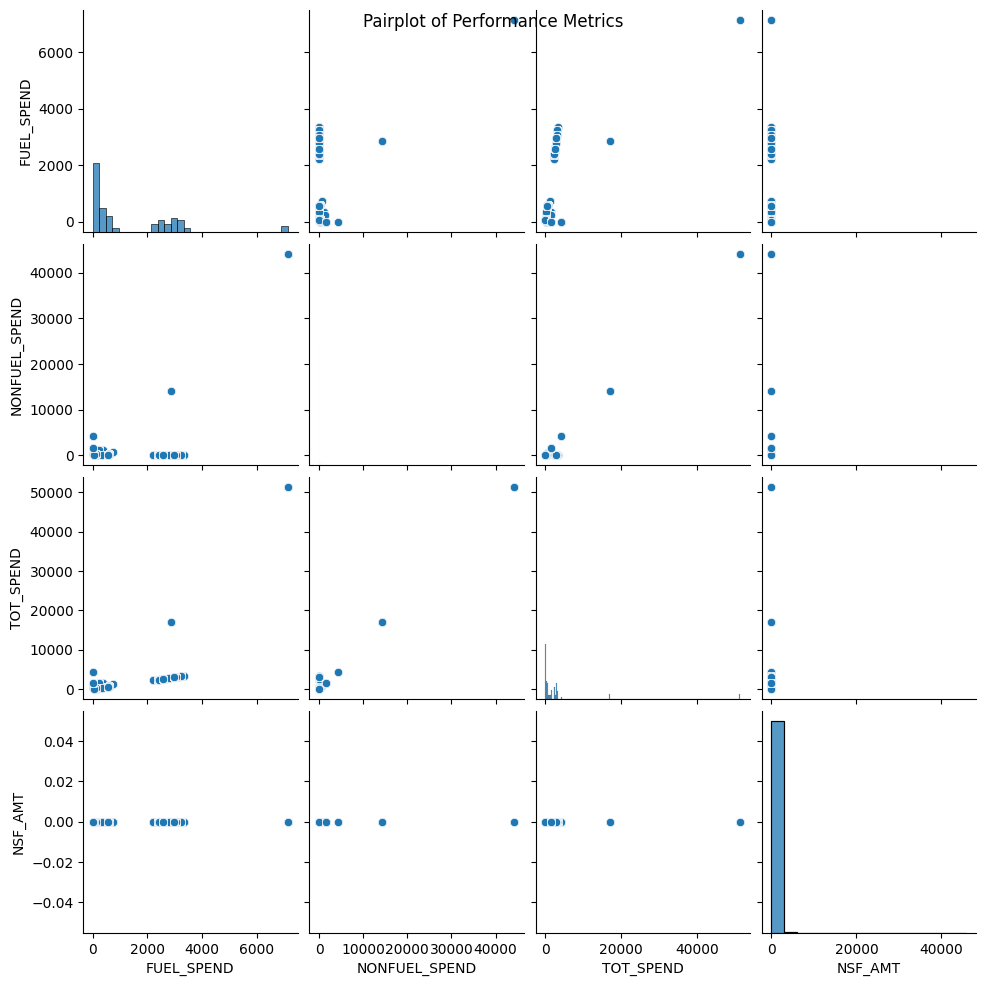

In [18]:
# Visualize Performance Metrics
sns.pairplot(data[performance_metrics])
plt.suptitle("Pairplot of Performance Metrics")
plt.show()

C:\Users\kiruj\AppData\Local\Temp\ipykernel_11980\2942081707.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bad_rate_by_bins = data.groupby('CLI_Binned')['Bad_Payment'].mean()


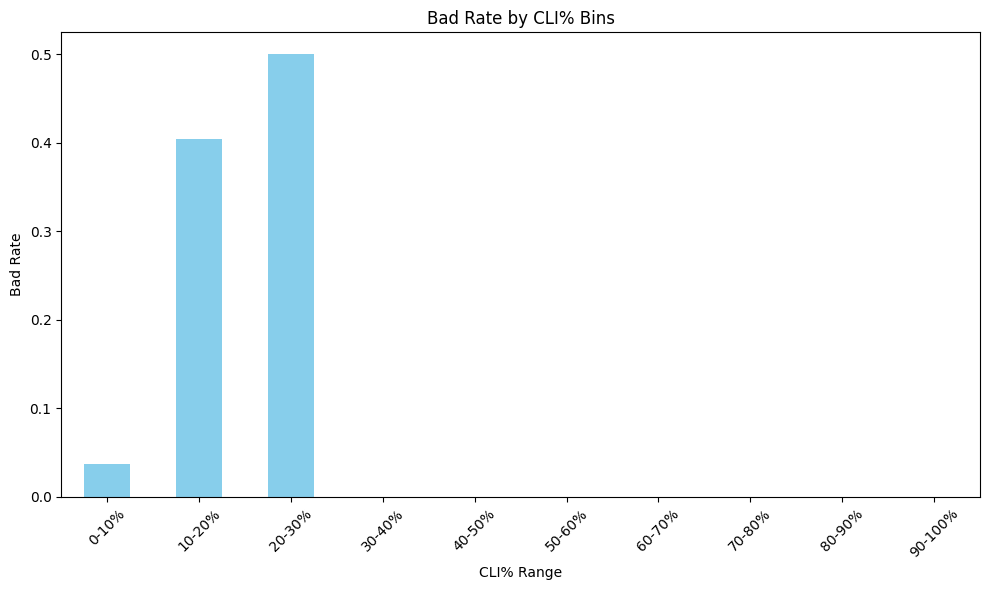

Bad Rate by CLI% Bins:
CLI_Binned
0-10%      0.037472
10-20%     0.404494
20-30%     0.500000
30-40%     0.000000
40-50%     0.000000
50-60%     0.000000
60-70%     0.000000
70-80%          NaN
80-90%          NaN
90-100%         NaN
Name: Bad_Payment, dtype: float64


In [24]:
# 3. Sensitivity Analysis with Binned CLI%
# Define bins for CLI percentages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Create a new column for CLI percentage bins
data['CLI_Binned'] = pd.cut(data['CLI_percentage'], bins=bins, labels=labels, include_lowest=True)

# Calculate the bad rate by CLI percentage bins
bad_rate_by_bins = data.groupby('CLI_Binned')['Bad_Payment'].mean()

# Plot the bad rate for each bin
plt.figure(figsize=(10, 6))
bad_rate_by_bins.plot(kind='bar', color='skyblue', title='Bad Rate by CLI% Bins')
plt.xlabel('CLI% Range')
plt.ylabel('Bad Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Bad Rate by CLI% Bins:")
print(bad_rate_by_bins)


Fuel-Only Count: 223
Universal Count: 9442
Spend and Loss Differences (Fuel-Only vs Universal):
{'Fuel-Only': TOT_SPEND     0.000000
NSF_AMT      95.494843
dtype: float64, 'Universal': TOT_SPEND    2720.843859
NSF_AMT        62.983580
dtype: float64}


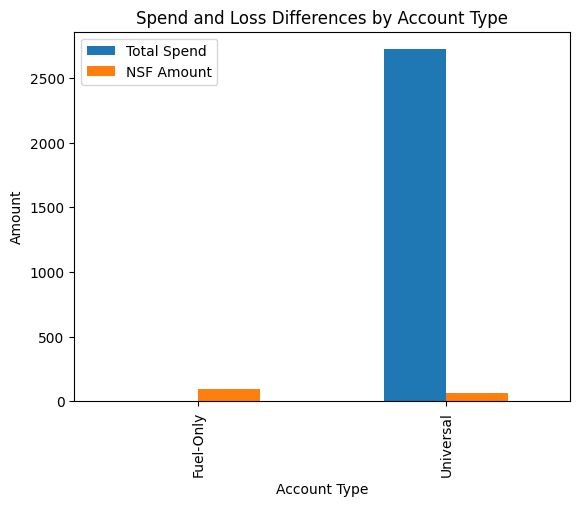

In [32]:
# Segment opt-in customers into Fuel-Only and Universal Card customers
fuel_only = data[data['CARD_TYPE'] == 'Fuel-only card']
universal = data[data['CARD_TYPE'] == 'Universal card']

# Recheck group counts
print(f"Fuel-Only Count: {len(fuel_only)}")
print(f"Universal Count: {len(universal)}")

if len(fuel_only) > 0 and len(universal) > 0:
    # Calculate spend and loss differences
    spend_loss_diff = {
        "Fuel-Only": fuel_only[['TOT_SPEND', 'NSF_AMT']].mean(),
        "Universal": universal[['TOT_SPEND', 'NSF_AMT']].mean()
    }
    print("Spend and Loss Differences (Fuel-Only vs Universal):")
    print(spend_loss_diff)

    # Visualize Spend and Loss
    spend_loss_df = pd.DataFrame(spend_loss_diff).T
    spend_loss_df.columns = ['Total Spend', 'NSF Amount']
    spend_loss_df.plot(kind='bar', title='Spend and Loss Differences by Account Type')
    plt.xlabel('Account Type')
    plt.ylabel('Amount')
    plt.show()
else:
    print("One or both groups are empty after segmentation. Review data preparation steps.")


In [34]:
# Handle Missing Values
data[['TOT_SPEND', 'FUEL_SPEND', 'NONFUEL_SPEND', 'NSF_AMT']] = data[['TOT_SPEND', 'FUEL_SPEND', 'NONFUEL_SPEND', 'NSF_AMT']].fillna(0)

# Ensure CLI Percentage is properly calculated
if 'CREDIT_LIMIT_INCREASE' in data.columns and 'CREDIT_LIMIT' in data.columns:
    data['CLI_percentage'] = (data['CREDIT_LIMIT_INCREASE'] / data['CREDIT_LIMIT']) * 100
    data['CLI_percentage'] = data['CLI_percentage'].fillna(0)

# Generate Performance Summary
performance_columns = ['TOT_SPEND', 'FUEL_SPEND', 'NONFUEL_SPEND', 'NSF_AMT', 'CLI_percentage']
summary = data.groupby(['Year', 'Quarter'])[performance_columns].mean()
print("Cross-Sell Performance Summary (Updated):")
print(summary)


Cross-Sell Performance Summary (Updated):
                 TOT_SPEND   FUEL_SPEND  NONFUEL_SPEND      NSF_AMT  \
Year Quarter                                                          
2018 2018Q3       0.000000     0.000000       0.000000     0.000000   
     2018Q4       0.000000     0.000000       0.000000    72.856500   
2019 2019Q1       0.000000     0.000000       0.000000    36.305926   
     2019Q2       0.000000     0.000000       0.000000     0.000000   
     2019Q3       0.000000     0.000000       0.000000     0.000000   
     2019Q4       0.000000     0.000000       0.000000    49.303235   
2020 2020Q1       0.000000     0.000000       0.000000   106.493611   
     2020Q2       0.000000     0.000000       0.000000     0.000000   
     2020Q4       0.000000     0.000000       0.000000     0.000000   
2021 2021Q1       0.000000     0.000000       0.000000     0.000000   
     2021Q2       0.000000     0.000000       0.000000     0.000000   
     2021Q3       0.000000     0.00

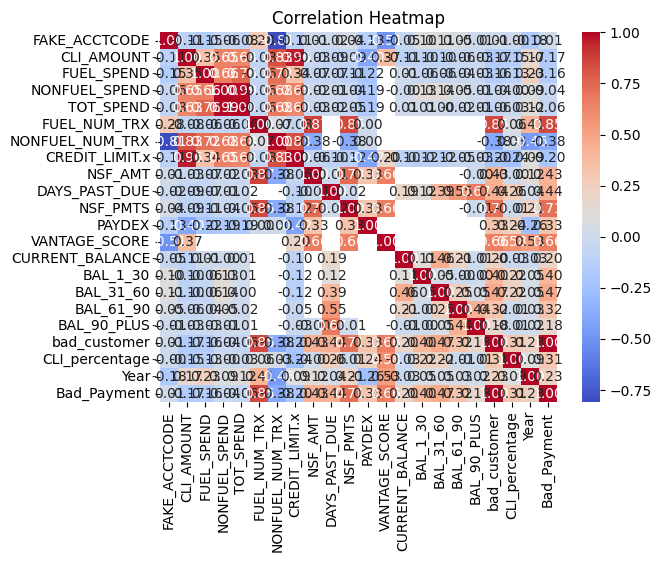

In [36]:
# Ensure only numeric columns are used for correlation analysis
numeric_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation = numeric_data.corr()

# Visualize the correlation heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [37]:
# Decision Tree Model for Eligibility Evaluation
features = ['FUEL_SPEND', 'NONFUEL_SPEND', 'TOT_SPEND', 'CLI_percentage']
target = 'bad_customer'
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Display Decision Tree Rules
print("Decision Tree Rules:")
print(export_text(model, feature_names=features))


Model Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2750
           1       0.44      0.03      0.05       150

    accuracy                           0.95      2900
   macro avg       0.70      0.51      0.51      2900
weighted avg       0.92      0.95      0.93      2900

Confusion Matrix:
[[2745    5]
 [ 146    4]]
Decision Tree Rules:
|--- FUEL_SPEND <= 11.28
|   |--- CLI_percentage <= 0.87
|   |   |--- TOT_SPEND <= 772.99
|   |   |   |--- CLI_percentage <= 0.68
|   |   |   |   |--- class: 0
|   |   |   |--- CLI_percentage >  0.68
|   |   |   |   |--- class: 0
|   |   |--- TOT_SPEND >  772.99
|   |   |   |--- class: 0
|   |--- CLI_percentage >  0.87
|   |   |--- CLI_percentage <= 1.01
|   |   |   |--- CLI_percentage <= 0.99
|   |   |   |   |--- class: 1
|   |   |   |--- CLI_percentage >  0.99
|   |   |   |   |--- class: 0
|   |   |--- CLI_percentage >  1.01
|   |   |   |--- NONFUEL_SPEND <= 146.63
|   |   |   | 

In [47]:
# Updated Eligibility Prediction
data['Revised_Eligibility'] = model.predict(X)
print(data[['bad_customer', 'Revised_Eligibility']].head())


   bad_customer  Revised_Eligibility
0             1                    0
1             0                    0
2             0                    0
3             0                    0
4             0                    0


In [41]:
# Assuming 'data' is your DataFrame with the relevant columns
features = ['FUEL_SPEND', 'NONFUEL_SPEND', 'TOT_SPEND', 'CLI_percentage']
target = 'bad_customer'

X = data[features]
y = data[target]

# Step 1: Check and handle missing values in X
print("Missing values in X:")
print(X.isnull().sum())

# Step 2: Handle missing values (fill with mean for example)
X = X.fillna(X.mean())

# Step 3: Check for infinite values in X
print("\nInfinite values in X:")
print(np.isinf(X).sum())

# Step 4: Replace infinite values with NaN and then fill them with the mean
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Step 5: Split the data for Decision Tree Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree Model for Eligibility Evaluation
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Step 6: Evaluate Decision Tree Performance
print("Decision Tree Model Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Display Decision Tree Rules
print("Decision Tree Rules:")
print(export_text(model, feature_names=features))

# Step 7: Apply Logistic Regression for Revised Eligibility Model
logit_model = sm.Logit(y, sm.add_constant(X))  # Add constant for intercept term
result = logit_model.fit()

# Step 8: Display Logistic Regression Summary
print("Logistic Regression Model Summary:")
print(result.summary())

Missing values in X:
FUEL_SPEND         0
NONFUEL_SPEND      0
TOT_SPEND          0
CLI_percentage    15
dtype: int64

Infinite values in X:
FUEL_SPEND        0
NONFUEL_SPEND     0
TOT_SPEND         0
CLI_percentage    0
dtype: int64
Decision Tree Model Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2750
           1       0.44      0.03      0.05       150

    accuracy                           0.95      2900
   macro avg       0.70      0.51      0.51      2900
weighted avg       0.92      0.95      0.93      2900

Confusion Matrix:
[[2745    5]
 [ 146    4]]
Decision Tree Rules:
|--- FUEL_SPEND <= 11.28
|   |--- CLI_percentage <= 0.87
|   |   |--- TOT_SPEND <= 772.99
|   |   |   |--- CLI_percentage <= 0.68
|   |   |   |   |--- class: 0
|   |   |   |--- CLI_percentage >  0.68
|   |   |   |   |--- class: 0
|   |   |--- TOT_SPEND >  772.99
|   |   |   |--- class: 0
|   |--- CLI_percentage >  0.87
|   |   |--- CLI_pe

C:\Users\kiruj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Create a Logistic Regression model (from sklearn)
logit_model = LogisticRegression()

# Cross-validation for Logistic Regression
logit_cv_scores = cross_val_score(logit_model, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", logit_cv_scores)
print("Mean Cross-Validation Accuracy for Logistic Regression:", np.mean(logit_cv_scores))


Logistic Regression Cross-Validation Accuracy Scores: [0.92809105 0.94878427 0.94878427 0.94774961 0.94309364]
Mean Cross-Validation Accuracy for Logistic Regression: 0.9433005690636318


In [46]:
# Export Results
data.to_csv('revised_eligibility_results.csv', index=False)
print("Analysis complete. Results saved to 'revised_eligibility_results.csv'")


Analysis complete. Results saved to 'revised_eligibility_results.csv'


In [48]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

# Example data (replace with your actual dataset)
# Assuming X and y are your features and target
# X = your feature data
# y = your target variable (bad_customer)

# Split data into training and testing sets (optional, for testing purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Logistic Regression model
logit_model = LogisticRegression()

# Fit the model
logit_model.fit(X_train, y_train)

# Predict the 'Revised_Eligibility' (predicted eligibility based on the model)
predicted_eligibility = logit_model.predict(X_test)

# Create a DataFrame to compare 'bad_customer' and 'Revised_Eligibility'
results_df = pd.DataFrame({
    'bad_customer': y_test,  # actual values
    'Revised_Eligibility': predicted_eligibility  # predicted values
})

# Display the DataFrame
print(results_df)

# Optionally, calculate cross-validation scores
logit_cv_scores = cross_val_score(logit_model, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", logit_cv_scores)
print("Mean Cross-Validation Accuracy for Logistic Regression:", np.mean(logit_cv_scores))


      bad_customer  Revised_Eligibility
6846             0                    0
6897             0                    0
6774             0                    0
1318             0                    0
39               1                    0
...            ...                  ...
2641             0                    0
3381             0                    0
6828             0                    0
7588             0                    0
7064             0                    0

[2900 rows x 2 columns]
Logistic Regression Cross-Validation Accuracy Scores: [0.92809105 0.94878427 0.94878427 0.94774961 0.94309364]
Mean Cross-Validation Accuracy for Logistic Regression: 0.9433005690636318
